In [21]:
import pandas as pd
import numpy as np
from core import Backtest, PlotPoint, IStrategy
from binance.enums import HistoricalKlinesType
from binance import Client
from multiprocessing import Pool
from math import log
from datetime import datetime
import optuna
import talib

In [22]:
class MA(IStrategy):
    def __init__(self, symbol1, symbol2, ma_span, kill, offset, ex, z_treshold, z_span, quantity=0.002):
        self.ma = []
        self.diff = []
        self.data1 = []
        self.quantity = quantity
        self.data2 = []
        self.ex = ex
        self.upper = []
        self.middle = []
        self.lower = []
        self.ma_span = ma_span
        self.ema_alpha = 0
        self.scale = -1
        self.position = 0
        self.enter_price = None
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.offset = offset
        self.trades = []
        self.z_span = z_span
        self.z_treshold = z_treshold
        self.up_or_down = 0
        self.lets_wait_after_buy = 0
        self.lets_wait_after_sell = 0
        self.kill = kill
        self.zscore = []

    def _update_bbands(self, feeds):
        close1 = feeds[self.symbol1].close[-self.ma_span:]
        close2 = feeds[self.symbol2].close[-self.ma_span:]
        upper, middle, lower = talib.BBANDS(np.array(close1) - np.array(close2) * self.scale, timeperiod=self.ma_span)
        self.upper.append(upper[-1])
        self.middle.append(middle[-1])
        self.lower.append(lower[-1])

    def _update_zscore(self, feeds):
        close1 = feeds[self.symbol1].close[-self.z_span:]
        close2 = feeds[self.symbol2].close[-self.z_span:]
        prices = pd.DataFrame(data={'Close_x': close1, 'Close_y' : close2})
        # res = sm.ols(formula="Close_x~Close_y", data=prices).fit()
        # b = res.params.Close_y
        b = sum(close1) / (sum(close2) * self.scale)
        spread = prices.Close_x- prices.Close_y*b
        zs = (spread - np.mean(spread))/np.std(spread)
        self.zscore.append(zs.iloc[-1])

    def make_decision(self, feeds):
        if self.scale <= 0:
            self.scale = feeds[self.symbol1].close[0]/feeds[self.symbol2].close[0]
        self.ma = self.middle
        self._update_bbands(feeds)
        self.diff.append(feeds[self.symbol1].close[-1] - feeds[self.symbol2].close[-1] * self.scale)

        if len(self.diff) < max(self.ma_span, self.ex):
            return dict()

        self._update_zscore(feeds)
        if (self.position == 1) & (np.array(self.diff[-self.ex::]).mean() < self.ma[-1]) & (self.diff[-1] > self.ma[-1]):
            self.up_or_down = 1
        elif (self.position == -1) & (np.array(self.diff[-self.ex::]).mean() > self.ma[-1]) & (self.diff[-1] < self.ma[-1]):
            self.up_or_down = -1
        else:
            self.up_or_down = 0
        if self.lets_wait_after_buy == 1:
            if self.ma[-1] <= self.diff[-1]:
                self.lets_wait_after_buy = 0
            else:
                return dict()
        elif self.lets_wait_after_sell == 1:
            if self.ma[-1] >= self.diff[-1]:
                self.lets_wait_after_sell = 0
            else:
                return dict()

        if (self.lets_wait_after_buy == 1) | (self.lets_wait_after_sell == 1):
            return dict()


        if self.position == 1:
            if (self.diff[-1] - self.enter_price > self.kill*(self.upper[-1] - self.middle[-1])) | \
                    ((self.ma[-1] - self.diff[-1]) > self.offset*(self.middle[-1] - self.lower[-1])) | (self.up_or_down == 1)  | ((abs(self.zscore[-1]))  <= (self.z_treshold/2)):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='exit_sell',
                    value=self.diff[-1]
                ))
                if (self.diff[-1] - self.enter_price > self.kill*(self.upper[-1] - self.middle[-1])) | (self.up_or_down == 1):
                    self.lets_wait_after_sell = 1

                return dict()
            else:
                return {self.symbol1: -self.quantity, self.symbol2: self.quantity}

        elif self.position == -1:
            if (self.enter_price - self.diff[-1] > self.kill*(self.middle[-1] - self.lower[-1])) | \
                    ((self.diff[-1] - self.ma[-1]) > self.offset*(self.upper[-1] - self.middle[-1])) | (self.up_or_down == -1) | ((abs(self.zscore[-1]))  <= (self.z_treshold/2)):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='exit_buy',
                    value=self.diff[-1]
                ))
                if (self.enter_price - self.diff[-1] > self.kill*(self.middle[-1] - self.lower[-1])) | (self.up_or_down == -1):
                    self.lets_wait_after_buy = 1

                return dict()
            else:
                return {self.symbol1: self.quantity, self.symbol2: -self.quantity}
        else:
            if self.diff[-1] - self.ma[-1] > self.offset*(self.upper[-1] - self.middle[-1]) and \
                    self.zscore[-1] >= self.z_treshold:
                self.position = 1
                self.enter_price = self.diff[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='enter_sell',
                    value=self.diff[-1]
                ))
                return {self.symbol1: -self.quantity, self.symbol2: self.quantity}
            elif self.ma[-1] - self.diff[-1] > self.offset*(self.middle[-1] - self.lower[-1]) and \
                    self.zscore[-1] <= -self.z_treshold:
                self.position = -1
                self.enter_price = self.diff[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.diff) - 1,
                    name='enter_buy',
                    value=self.diff[-1]
                ))
                return {self.symbol1: self.quantity, self.symbol2: -self.quantity}
            else:
                return dict()

    def get_plot_lines(self):
        return [{'{} - {}'.format(self.symbol1, self.symbol2): self.diff,
                 'MA span={}'.format(self.ma_span): self.ma,
                 'Upper bound= {}'.format(self.ma_span): self.upper,
                 'Lower bound= {}'.format(self.ma_span): self.lower}]

    def get_plot_points(self):
        return [self.trades]

    def get_name(self):
        return 'MA {}, {}'.format(self.symbol1, self.symbol2)

In [23]:
apiKey='123'
apiSec='321'

columns = [
    "Open time", "Open", "High", "Low", "Close", "Volume", "Close time",
    "Quote asset volume", "Number of trades", "Taker buy base asset volume",
    "Taker buy quote asset volume", "Ignore"
]

client=Client(apiKey,apiSec)
candles_eth = client.get_historical_klines('ETHUSDT', Client.KLINE_INTERVAL_1MINUTE, "7 day ago UTC", klines_type=HistoricalKlinesType.FUTURES)

train_e = pd.DataFrame(candles_eth).set_index(0)
train_e.index = [datetime.utcfromtimestamp(train_e.index[i]/1000).strftime('%Y-%m-%d %H:%M:%S') for i in range(train_e.shape[0])]
train_e.columns = columns[1:12]
train_e.Close = train_e.Close.apply(lambda x: float(x))
train_e.Volume = train_e.Volume.apply(lambda x: float(x))

In [24]:
for coin in ['COMPUSDT']:
    candles_n = client.get_historical_klines(coin, Client.KLINE_INTERVAL_1MINUTE,  "7 day ago UTC", klines_type=HistoricalKlinesType.FUTURES)

    train_n = pd.DataFrame(candles_n).set_index(0)
    train_n.index = [datetime.utcfromtimestamp(train_n.index[i]/1000).strftime('%Y-%m-%d %H:%M:%S') for i in range(train_n.shape[0])]
    train_n.columns = columns[1:12]
    train_n.Close = train_n.Close.apply(lambda x: float(x))
    train_n.Volume = train_n.Volume.apply(lambda x: float(x))


    train = pd.merge(train_n, train_e, left_index=True, right_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:05<00:00, 1901.83it/s]


{'total_profit': 0.086562400000001, 'num_trades': 22, 'sortino_ratio': 0.007602130397764072, 'return, %': 3.109527333338159}


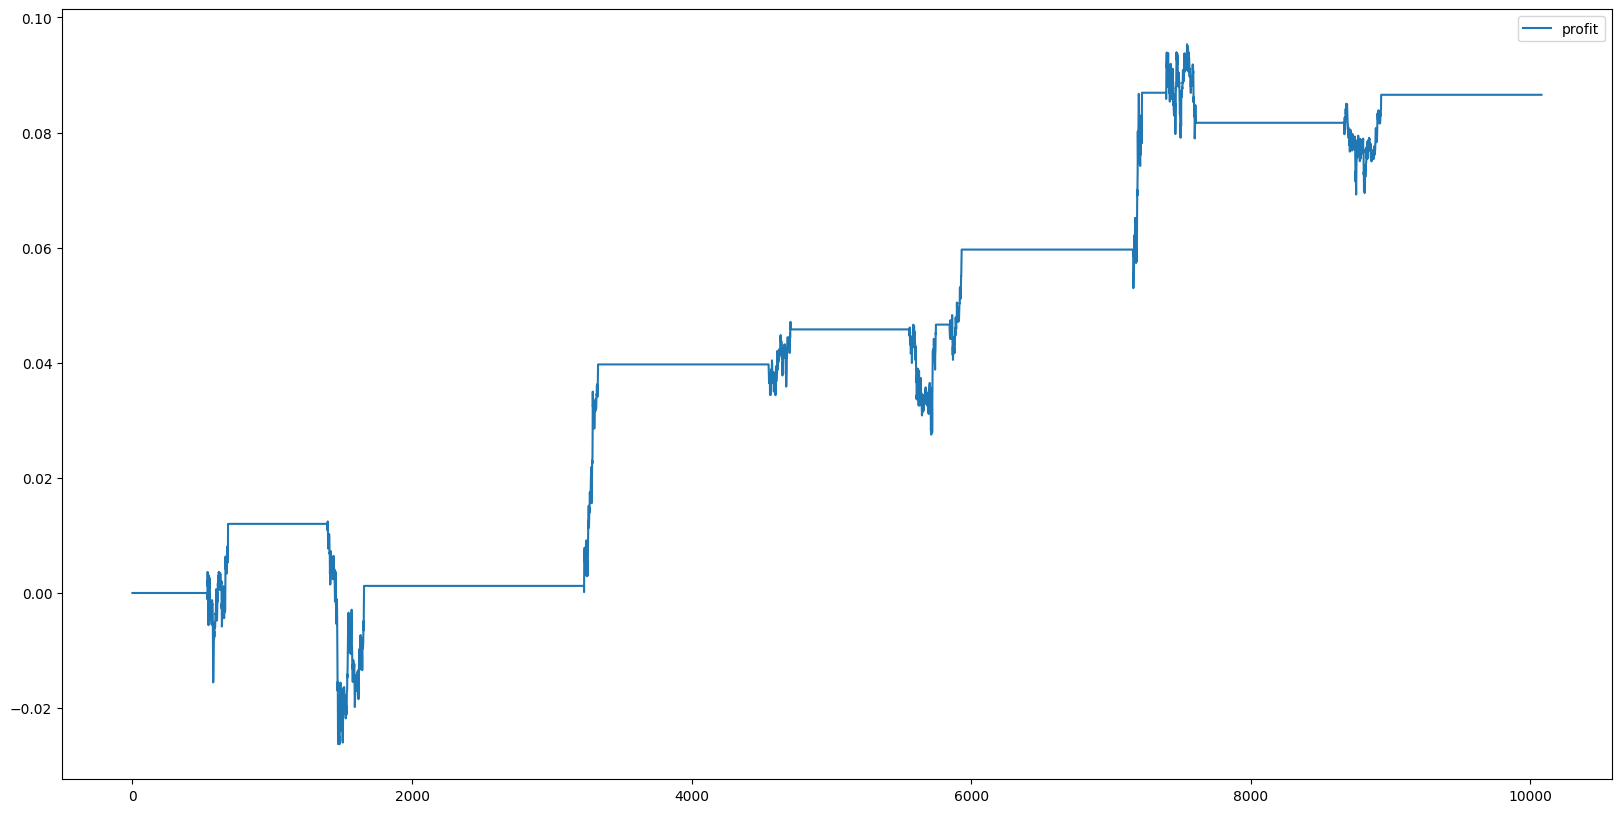

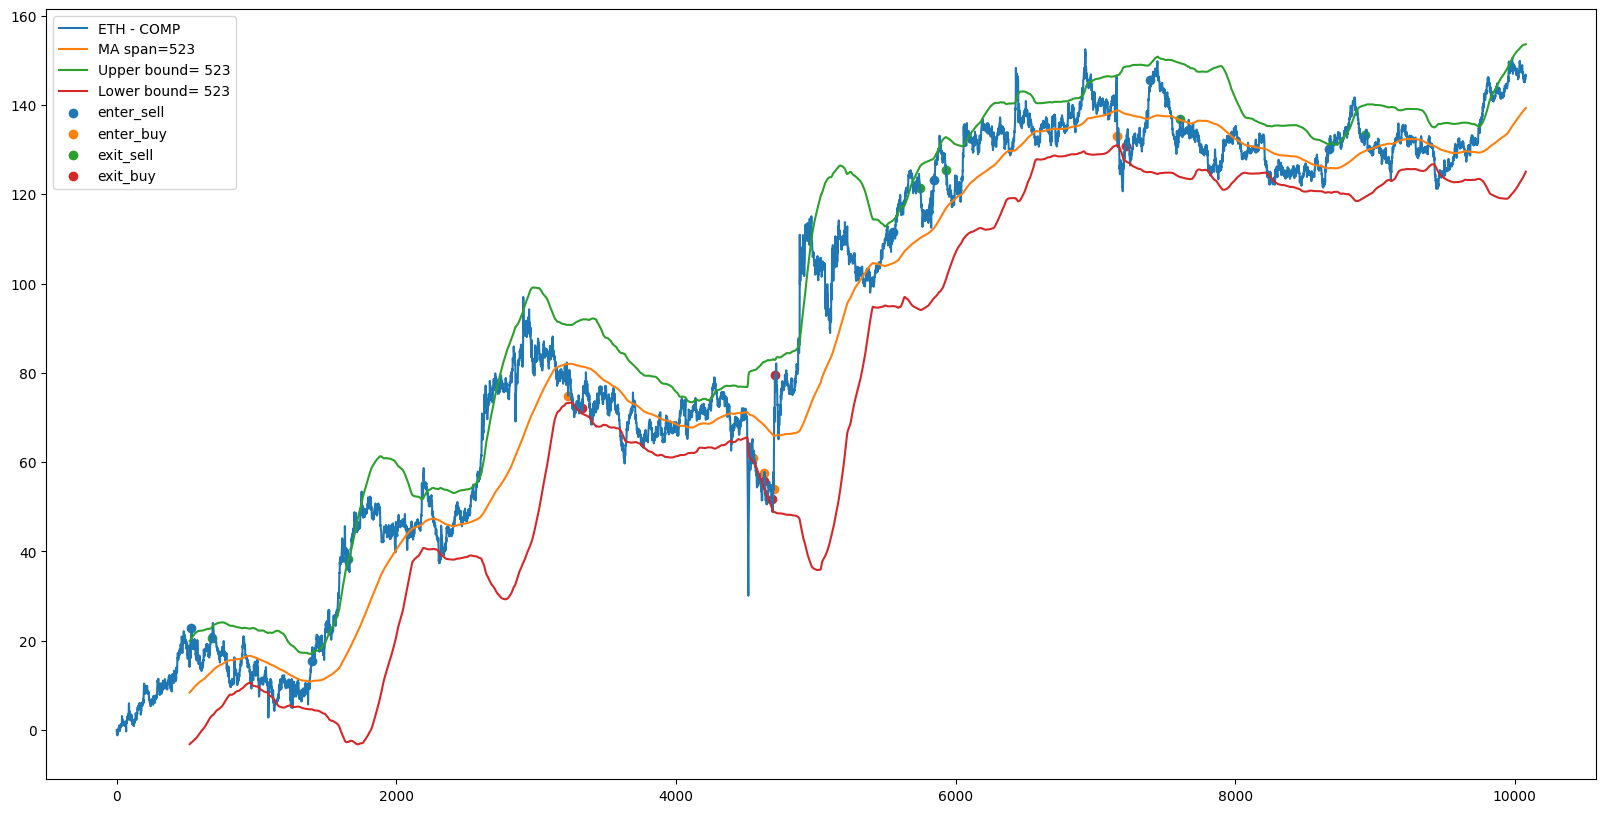

In [25]:
feeds = {
    'ETH': pd.DataFrame({'Close':train.Close_y}), 'COMP' : pd.DataFrame({'Close':train.Close_x})
}

param = {
    'ma_span': 523,
    'kill': 1.849365539590282,
    'offset': 0.6622826410696923,
    'ex': 5,
    'z_treshold': 1.2880626884903394,
    'z_span': 824,
    'symbol1': 'ETH',
    'symbol2': 'COMP',
    'quantity': 0.002
}

strategy = MA(**param)
bt = Backtest(feeds, strategy) # commision=0,0004
res, trades = bt.run(plot=True)
print(res)

In [26]:
train

,Open_x,High_x,Low_x,Close_x,Volume_x,Close time_x,Quote asset volume_x,Number of trades_x,Taker buy base asset volume_x,Taker buy quote asset volume_x,...,High_y,Low_y,Close_y,Volume_y,Close time_y,Quote asset volume_y,Number of trades_y,Taker buy base asset volume_y,Taker buy quote asset volume_y,Ignore_y
2022-10-16 13:11:00,54.75,54.75,54.72,54.73,35.388,1665925919999,1937.27319,18,3.631,198.72463,...,1283.40,1283.07,1283.07,1110.666,1665925919999,1425287.66927,639,363.891,466970.67263,0
2022-10-16 13:12:00,54.73,54.75,54.73,54.74,39.833,1665925979999,2180.70022,14,36.154,1979.31176,...,1283.29,1282.82,1282.82,735.213,1665925979999,943343.37239,789,311.176,399266.96994,0
2022-10-16 13:13:00,54.74,54.75,54.72,54.74,67.301,1665926039999,3683.66742,38,26.453,1448.05618,...,1282.83,1282.38,1282.38,1716.441,1665926039999,2201431.53778,918,392.120,502908.99438,0
2022-10-16 13:14:00,54.74,54.74,54.72,54.72,66.541,1665926099999,3641.15374,11,0.474,25.94676,...,1282.39,1282.00,1282.00,489.193,1665926099999,627240.53437,496,43.264,55473.52264,0
2022-10-16 13:15:00,54.71,54.73,54.70,54.71,195.200,1665926159999,10681.01653,58,75.823,4148.93734,...,1282.11,1281.57,1281.67,1612.141,1665926159999,2066614.93917,1045,773.825,991975.68734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-23 13:06:00,49.48,49.51,49.47,49.51,263.413,1666530419999,13035.19208,28,248.203,12282.60290,...,1306.44,1305.83,1306.33,1390.173,1666530419999,1815767.01663,695,766.462,1001049.93373,0
2022-10-23 13:07:00,49.50,49.50,49.47,49.47,60.004,1666530479999,2969.33480,32,30.338,1501.31709,...,1306.46,1306.10,1306.11,1129.643,1666530479999,1475691.07866,485,485.868,634667.49917,0
2022-10-23 13:08:00,49.48,49.48,49.48,49.48,0.192,1666530539999,9.50016,2,0.192,9.50016,...,1306.56,1306.11,1306.55,332.662,1666530539999,434592.48993,359,177.063,231316.67030,0
2022-10-23 13:09:00,49.47,49.48,49.47,49.47,3.891,1666530599999,192.50041,9,1.264,62.54272,...,1306.61,1306.27,1306.56,1389.699,1666530599999,1815640.75535,629,628.868,821559.22500,0


# Train-Train

In [30]:
train = train.iloc[0:100]

In [31]:
def objective(trial):
    param = {
        'symbol1' : 'ETH',
        'symbol2' : 'COMP',        
        'ma_span' :  trial.suggest_int('ma_span', 500, 1500),
        'kill' : trial.suggest_float('kill', 1, 2),
        'offset' : trial.suggest_float('offset', 0.6, 1.2),   
        'ex' : trial.suggest_int('ex', 2, 5),
        'z_treshold' : trial.suggest_float('z_treshold', 1.25, 2.5),
        'z_span' : trial.suggest_int('z_span', 500, 1500),
        'quantity' : 0.002
    }

    strategy = MA(**param)
    bt = Backtest(feeds, strategy)
    res, mas = bt.run(plot=False)
    s_r = res['sortino_ratio']
    if np.isnan(s_r):
        s_r = 0
    return s_r

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

res_params = study.best_params
res_params['symbol1'] = 'ETH'
res_params['symbol2'] = 'COMP'
res_params['quantity'] = 0.002

[I 2022-10-23 16:15:43,343] A new study created in memory with name: no-name-e94a022e-a7bf-47db-820a-5b3b484b26af
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:05<00:00, 1835.05it/s]
[I 2022-10-23 16:15:48,857] Trial 0 finished with value: 0.004415366866097757 and parameters: {'ma_span': 791, 'kill': 1.7978275544503322, 'offset': 1.1075656426499432, 'ex': 5, 'z_treshold': 2.120917221324251, 'z_span': 870}. Best is trial 0 with value: 0.004415366866097757.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:04<00:00, 2164.74it/s]
[I 2022-10-23 16:15:53,527] Trial 1 finished with value: 0.002261926839256702 and parameters: {'ma_span': 1434, 'kill': 1.130930532347393, 'offset': 0.7743237311459217, 'ex': 5, 'z_treshold': 2.1032657019798746, 'z_span': 520}. Best is trial 0 with value: 0.004415366866097

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1554.53it/s]
[I 2022-10-23 16:17:53,082] Trial 18 finished with value: 0.008567573255020042 and parameters: {'ma_span': 529, 'kill': 1.5517712437644253, 'offset': 0.912810921006834, 'ex': 2, 'z_treshold': 1.9572231635256925, 'z_span': 1340}. Best is trial 11 with value: 0.012053296971649832.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1562.56it/s]
[I 2022-10-23 16:17:59,553] Trial 19 finished with value: 0.00480188596747685 and parameters: {'ma_span': 742, 'kill': 1.8390077737112869, 'offset': 1.0606311963017723, 'ex': 3, 'z_treshold': 2.2850594998062843, 'z_span': 1333}. Best is trial 11 with value: 0.012053296971649832.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:05<00:00, 1690.97it/s]
[I 2022-10-23 16:19:47,095] Trial 36 finished with value: 0.0025833162374556437 and parameters: {'ma_span': 1492, 'kill': 1.4351939530618212, 'offset': 0.8558339242187168, 'ex': 3, 'z_treshold': 1.7894334805455339, 'z_span': 1107}. Best is trial 25 with value: 0.015002255017782512.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1606.73it/s]
[I 2022-10-23 16:19:53,392] Trial 37 finished with value: 0.0021450257249384136 and parameters: {'ma_span': 876, 'kill': 1.4803273458373518, 'offset': 0.7862607648953599, 'ex': 4, 'z_treshold': 1.6305002443844012, 'z_span': 1228}. Best is trial 25 with value: 0.015002255017782512.
100%|██████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1644.54it/s]
[I 2022-10-23 16:21:37,717] Trial 54 finished with value: 0.00718154279403004 and parameters: {'ma_span': 542, 'kill': 1.9318930802154033, 'offset': 0.6655907105592798, 'ex': 5, 'z_treshold': 2.0607339565894494, 'z_span': 1151}. Best is trial 25 with value: 0.015002255017782512.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1639.62it/s]
[I 2022-10-23 16:21:43,887] Trial 55 finished with value: 0.006296067480027122 and parameters: {'ma_span': 829, 'kill': 1.8793699387410026, 'offset': 0.9493288032501692, 'ex': 5, 'z_treshold': 1.9169823332584195, 'z_span': 1176}. Best is trial 25 with value: 0.015002255017782512.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1661.70it/s]
[I 2022-10-23 16:23:28,599] Trial 72 finished with value: 0.012195483994943026 and parameters: {'ma_span': 521, 'kill': 1.5832339493779042, 'offset': 0.8240709288793986, 'ex': 2, 'z_treshold': 1.6804432244405245, 'z_span': 1125}. Best is trial 25 with value: 0.015002255017782512.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1669.70it/s]
[I 2022-10-23 16:23:34,659] Trial 73 finished with value: 0.011709083405520607 and parameters: {'ma_span': 575, 'kill': 1.5934859802608115, 'offset': 0.8249856879149539, 'ex': 2, 'z_treshold': 1.809501995899907, 'z_span': 1120}. Best is trial 25 with value: 0.015002255017782512.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1571.93it/s]
[I 2022-10-23 16:25:23,983] Trial 90 finished with value: 0.00897108004845341 and parameters: {'ma_span': 594, 'kill': 1.697326078796219, 'offset': 0.9933923689943781, 'ex': 2, 'z_treshold': 1.5374751718812556, 'z_span': 1247}. Best is trial 75 with value: 0.016062774841770405.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10080/10080 [00:06<00:00, 1616.04it/s]
[I 2022-10-23 16:25:30,244] Trial 91 finished with value: 0.011882413677486835 and parameters: {'ma_span': 526, 'kill': 1.618447295928245, 'offset': 0.7480807481126593, 'ex': 2, 'z_treshold': 1.7145177900325632, 'z_span': 1144}. Best is trial 75 with value: 0.016062774841770405.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████

In [32]:
res_params

{'ma_span': 500,
 'kill': 1.566660204572959,
 'offset': 0.8136636589078015,
 'ex': 2,
 'z_treshold': 1.769359586218426,
 'z_span': 1126,
 'symbol1': 'ETH',
 'symbol2': 'COMP',
 'quantity': 0.002}

# Train-Test

In [ ]:
def objective(trial):
    param = {
        'symbol1' : 'ETH',
        'symbol2' : 'COMP',        
        'ma_span' :  trial.suggest_int('ma_span', 500, 1500),
        'kill' : trial.suggest_float('kill', 1, 2),
        'offset' : trial.suggest_float('offset', 0.6, 1.2),   
        'ex' : trial.suggest_int('ex', 2, 5),
        'z_treshold' : trial.suggest_float('z_treshold', 1.25, 2.5),
        'z_span' : trial.suggest_int('z_span', 500, 1500),
        'quantity' : 0.002
    }
    strategy = Jma(**param)
    bt = Backtest(feeds, strategy)
    res, mas = bt.run(plot=False)
    s_r = res['sortino_ratio']
    if np.isnan(s_r):
        s_r = 0
    return s_r


window = 60*24*7
backtest_result = {}
print(datetime.now())


def period_return(args, position):
    feeds = {
    'ETH': train.iloc[position-1300:position+window]
    }
    
    strategy = Jma(**args)
    bt = Backtest(feeds, strategy)
    res, trades = bt.run(plot=False)
    return res['total_profit']

def f(args):
    strategy = Jma(*args)
    bt = Backtest(feeds, strategy)
    return bt.run(plot=False)


for step in range(0, train.shape[0]-3*window, window):
    print(datetime.now())    
    backtest = {}
    feeds = {
        'ETH': train.iloc[step:step+2*window]
    }
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=75)

    res_params = study.best_params
    res_params['symbol1'] = 'ETH'
    res_params['quantity'] = 0.002


    backtest['total_profit'] = period_return(res_params, step+1*window)
    backtest.update(res_params)
    
    backtest_result[train.iloc[step+2*window].name] = backtest